In [1]:

# Install required packages
!pip install youtube-transcript-api transformers scikit-learn rouge-score ipywidgets

  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=63e6dffa46a7d911dbb15cb656998db74e7abb99936fa0d3429bef40da09512f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [2]:

# Import libraries
from youtube_transcript_api import YouTubeTranscriptApi
from transformers import BartTokenizer, BartForConditionalGeneration
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from rouge_score import rouge_scorer
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import nltk

# Download necessary NLTK data
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

# Function to get transcript from YouTube video
def get_transcript(video_id):
    transcript = YouTubeTranscriptApi.get_transcript(video_id)
    return " ".join([entry['text'] for entry in transcript])

# Function to perform extractive summarization using TF-IDF
def extractive_summary(text, top_n=5):
    sentences = sent_tokenize(text)  # Use NLTK for sentence tokenization
    vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    scores = np.sum(cosine_sim, axis=1)
    ranked_sentences = [sentences[i] for i in np.argsort(scores, axis=0)[-top_n:]]
    return ' '.join(ranked_sentences)

# Function to perform abstractive summarization using BART
def abstractive_summary(text, tokenizer, model):
    max_length = 1024
    inputs = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=max_length)
    summary_ids = model.generate(inputs, max_length=150, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Function to evaluate summary using ROUGE
def evaluate_summary(generated_summary, reference_summary):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)
    return scores

# Hybrid summarization function
def hybrid_summary(video_id, reference_summary, top_n=5, chunk_size=1000):
    transcript = get_transcript(video_id)

    # Chunk the transcript for processing
    chunks = [transcript[i:i+chunk_size] for i in range(0, len(transcript), chunk_size)]

    # Extractive summarization for each chunk
    extractive_chunks = [extractive_summary(chunk, top_n) for chunk in chunks]
    combined_extractive_sum = ' '.join(extractive_chunks)

    # Abstractive summarization from the combined extractive summary
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
    abstractive_sum = abstractive_summary(combined_extractive_sum, tokenizer, model)

    # Evaluate summaries
    extractive_rouge_scores = evaluate_summary(combined_extractive_sum, reference_summary)
    abstractive_rouge_scores = evaluate_summary(abstractive_sum, reference_summary)

    return {
        'extractive_summary': combined_extractive_sum,
        'abstractive_summary': abstractive_sum,
        'rouge_scores': {
            'extractive': extractive_rouge_scores,
            'abstractive': abstractive_rouge_scores
        }
    }

# Provide a user interface using widgets
video_url_widget = widgets.Text(
    description='YouTube URL:',
    placeholder='Enter YouTube video URL'
)

reference_summary_widget = widgets.Textarea(
    description='Reference Summary:',
    placeholder='Enter reference summary',
    layout=widgets.Layout(width='100%', height='100px')
)

button = widgets.Button(description='Summarize')

def on_button_clicked(b):
    # Clear previous outputs
    clear_output(wait=True)

    video_url = video_url_widget.value
    reference_summary = reference_summary_widget.value

    try:
        video_id = video_url.split('v=')[1].split('&')[0]
        result = hybrid_summary(video_id, reference_summary)

        print('\nExtractive Summary:')
        print(result['extractive_summary'])

        print('\nAbstractive Summary:')
        print(result['abstractive_summary'])

        print('\nROUGE Scores:')
        print(result['rouge_scores'])

    except Exception as e:
        print(f'Error: {e}')

    # Re-display widgets
    display(video_url_widget, reference_summary_widget, button)

button.on_click(on_button_clicked)

# Display widgets
display(video_url_widget, reference_summary_widget, button)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]


Extractive Summary:
We're going to build this using a popular Python framework called Django. Hi, my name is Mosh, and I'm going to be your instructor in this Python course. We're going to talk about all the core concepts in Python, and then we're going to build three Python projects together. In this course I'm going to teach you everything  you need to get started with Python. In this course, you're going to learn everything you need to get started programming in Python. You're also going to learn how to use Python in machine learning, or artificial intelligence. You will write a Python program that will process thousands of spreadsheets in under a second. You can write your first Python program in literally seconds. So you will learn how to write a Python programming that will predict the music that people like based on their profile. I've designed this Python course for anyone who wants to learn Python. I'm super excited to be teaching you Python in this course. In this tutorial I

Text(value='https://www.youtube.com/watch?v=_uQrJ0TkZlc', description='YouTube URL:', placeholder='Enter YouTu…

Textarea(value='This 1-paragraph summary provides an overview of the video, "Python Tutorial - Python Full Cou…

Button(description='Summarize', style=ButtonStyle())

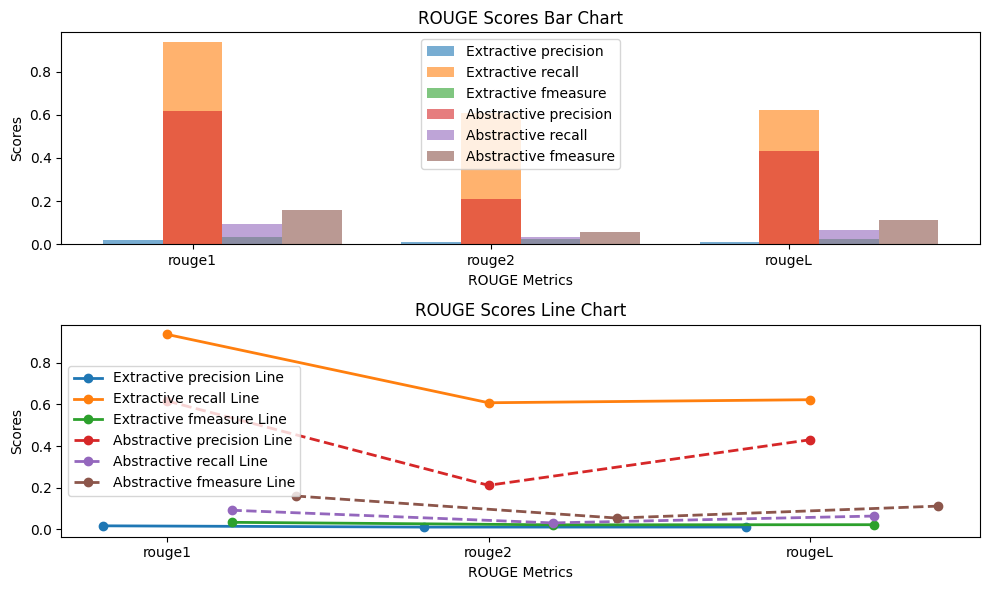

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# ROUGE scores data
scores = {
    'extractive': {
        'rouge1': {'precision': 0.0174, 'recall': 0.9357, 'fmeasure': 0.0342},
        'rouge2': {'precision': 0.0113, 'recall': 0.6080, 'fmeasure': 0.0222},
        'rougeL': {'precision': 0.0116, 'recall': 0.6226, 'fmeasure': 0.0228}
    },
    'abstractive': {
        'rouge1': {'precision': 0.6163, 'recall': 0.0922, 'fmeasure': 0.1604},
        'rouge2': {'precision': 0.2118, 'recall': 0.0314, 'fmeasure': 0.0546},
        'rougeL': {'precision': 0.4302, 'recall': 0.0643, 'fmeasure': 0.1120}
    }
}

# Labels
rouge_metrics = ['rouge1', 'rouge2', 'rougeL']
metrics = ['precision', 'recall', 'fmeasure']
x = np.arange(len(rouge_metrics))  # the label locations

# Width of the bars
width = 0.2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))

# Bar graph
# Plot bars for extractive
for i, metric in enumerate(metrics):
    extractive_scores = [scores['extractive'][rouge][metric] for rouge in rouge_metrics]
    ax1.bar(x - width + i * width, extractive_scores, width, label=f'Extractive {metric}', alpha=0.6)

# Plot bars for abstractive
for i, metric in enumerate(metrics):
    abstractive_scores = [scores['abstractive'][rouge][metric] for rouge in rouge_metrics]
    ax1.bar(x + i * width, abstractive_scores, width, label=f'Abstractive {metric}', alpha=0.6)

ax1.set_xlabel('ROUGE Metrics')
ax1.set_ylabel('Scores')
ax1.set_title('ROUGE Scores Bar Chart')
ax1.set_xticks(x)
ax1.set_xticklabels(rouge_metrics)
ax1.legend()

# Line graph
# Plot lines for extractive
for i, metric in enumerate(metrics):
    extractive_line = [scores['extractive'][rouge][metric] for rouge in rouge_metrics]
    ax2.plot(x - width + i * width, extractive_line, marker='o', linestyle='-', label=f'Extractive {metric} Line', linewidth=2)

# Plot lines for abstractive
for i, metric in enumerate(metrics):
    abstractive_line = [scores['abstractive'][rouge][metric] for rouge in rouge_metrics]
    ax2.plot(x + i * width, abstractive_line, marker='o', linestyle='--', label=f'Abstractive {metric} Line', linewidth=2)

ax2.set_xlabel('ROUGE Metrics')
ax2.set_ylabel('Scores')
ax2.set_title('ROUGE Scores Line Chart')
ax2.set_xticks(x)
ax2.set_xticklabels(rouge_metrics)
ax2.legend()

fig.tight_layout()

plt.show()

https://www.youtube.com/watch?v=_uQrJ0TkZlc

In [4]:
refernce summary:           This 1-paragraph summary provides an overview of the video, "Python Tutorial - Python Full Course for Beginners." In this video, Mosh explains how to install Python and a code editor, and how to start programming with Python. He also teaches beginners how to create a website in Python using a popular framework.
00:05:00 In this Python tutorial, we will learn how to write basic Python code and see its results. We will also learn about some programming terms and how Python code gets executed.
00:10:00 In this Python tutorial, you'll learn about variables and how to use them to store data in a computer's memory. You'll also learn how to print out the value of a variable.
00:15:00 In this Python tutorial, you will learn how to use the input and print functions to receive user input and print messages.
00:20:00 This video covers the basics of Python programming, with examples of code that performs simple tasks. The video provides instructions on how to write a program that asks the user their birth year and calculates their age. When the user enters an invalid year, an error is generated and the user is directed to the appropriate line in the source code.
00:25:00 In this tutorial, you're going to learn about Python strings and how to use various string functions. You'll also learn how to convert strings into integers and floats, and how to use the input function to get user input. Finally, you'll see how to use the type function to determine the type of a variable.
00:30:00 This tutorial explains how to use double and single quotes to define strings in Python. It also covers how to use triple quotes to create strings that span multiple lines. Finally, it demonstrates how to use the indexing syntax to get a specific character from a string.
00:35:00 In this Python tutorial, we look at how to format strings for easy viewing. We define a variable msg to hold a formatted string, and then use that string to print messages on the terminal. However, this approach becomes more complex as our text becomes more complex. For more concise and easy-to-read code, we use formatted strings.
00:40:00 In this Python tutorial, the instructor covers how to use functions and methods to manipulate strings. He shows how to use the len and upper methods to calculate the number of characters in a string, and how to use the find method to find a specific character in a string.
00:45:00 In this Python tutorial, you learned about the arithmetic operators supported in the language. You also learned about the in operator, which produces a boolean value. You also learned about the find and replace methods, and the len function.
00:50:00 In this Python tutorial, you learned about the arithmetic operators and how to use the augmented assignment operator. You also learned about operator precedence and how it affects the order of operations. Finally, you were asked to solve a math problem and you correctly guessed that x would be 22 after the code was executed.
00:55:00 In this tutorial, we'll learn about the if statement in Python. We'll see how to write a program that makes decisions based on a condition, and then print out the results.

SyntaxError: leading zeros in decimal integer literals are not permitted; use an 0o prefix for octal integers (<ipython-input-4-9ce555cf9e87>, line 2)